# Federated Learning for Sequential (Text) data

In [1]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using PyTorch {torch.__version__}")

Training on cpu using PyTorch 2.4.0


In [2]:
import numpy as np

random_state = 42
np.random.seed(random_state)

## Load data

In [3]:
from dataset import load_dataset, create_dataloader

# Set the max length for sequences
MAX_LEN = 60

# Load the dataset
df, vocab, label_encoder = load_dataset(MAX_LEN)

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxkleinegger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Split the data
from sklearn.model_selection import train_test_split


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["category"], test_size=0.2, random_state=random_state
)

In [5]:
train_loader = create_dataloader(train_texts, train_labels, vocab, MAX_LEN)
test_loader = create_dataloader(test_texts, test_labels, vocab, MAX_LEN, shuffle=False)

## State of the art baseline

In [6]:
# Model hyperparameters
vocab_size = len(vocab)
output_size = len(label_encoder.classes_)

In [7]:
from bidirectional_lstm import BidirectionalLSTM

model = BidirectionalLSTM(
    vocab_size,
    output_size,
    padding_idx=vocab["<pad>"],
).to(DEVICE)

In [17]:
from model_utils import run_centralised

acc_baseline, _ = run_centralised(
    model, train_loader, test_loader, epochs=1, lr=0.01, verbose=True
)

100%|██████████| 1/1 [00:35<00:00, 35.63s/it]


Accuracy: 0.5171, Loss: 1.9988


## LSTM to be federated

In [8]:
# Model hyperparameters
vocab_size = len(vocab)
output_size = len(label_encoder.classes_)

In [9]:
from lstm import LSTM

model = LSTM(
    vocab_size,
    output_size,
    padding_idx=vocab["<pad>"],
).to(DEVICE)

In [10]:
from model_utils import run_centralised

acc_no_fed, _ = run_centralised(model, train_loader, test_loader, epochs=1, lr=0.01, verbose=True)

100%|██████████| 1/1 [00:17<00:00, 17.88s/it]


Accuracy: 0.3740, Loss: 2.4352


### Federated LSTM

In [10]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

#### Partition data

In [11]:
from dataset import partition_dataset

trainloaders, valloaders, testloader = partition_dataset(
    train_loader, test_loader, vocab, NUM_CLIENTS, BATCH_SIZE
)

##### Visualization

number of articles: 777


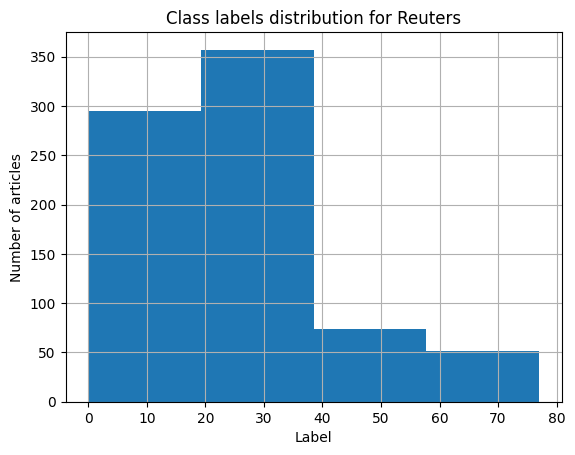

In [12]:
import matplotlib.pyplot as plt

# first partition
train_partition = trainloaders[1].dataset

# count data points
partition_indices = train_partition.indices
print(f"number of articles: {len(partition_indices)}")

# visualise histogram
plt.hist(
    [train_partition.dataset[idx][1].item() for idx in partition_indices], bins=4
)  # 46 classes in Reuters dataset
plt.grid()
plt.xlabel("Label")
plt.ylabel("Number of articles")
plt.title("Class labels distribution for Reuters")
plt.show()

#### Training

In [13]:
import flwr as fl

/Users/maxkleinegger/Desktop/test/speml.nosync/federated-text-classification/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-30 01:46:43,346	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [14]:
from fedarate_utils import generate_client_fn, get_evaluate_fn

client_fn_callback = generate_client_fn(model, trainloaders, valloaders)

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1, 
    fraction_evaluate=0.2,  
    min_available_clients=NUM_CLIENTS, 
    evaluate_fn=get_evaluate_fn(model, testloader),
)

history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-30 01:46:44,931	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7176468890.0, 'node:127.0.0.1': 1.0, 'CPU': 10.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
ERROR :     Traceback (most recent call last):
  File "/Users/maxkleinegger/Desktop/test/speml.nosync/federated-text-classification/venv/lib/python3.9/site-packages/flwr/simulation/ray_transport/ray_client_pr

RuntimeError: Simulation crashed.